In [1]:
import numpy as np
import pandas as pd
import seaborn

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#encoder
def my_one_hot_encoder(df, cat_features, cat_dict):
    tr_data = df.copy()

    new_cat_features = []

    for col in cat_features:
        uniq = cat_dict[col]
        for j, v in enumerate(uniq):
            tr_data[col+'_'+str(j)] = np.array(map(int, tr_data[col]==uniq[j]))
            new_cat_features += [col+'_'+str(j)]
    return tr_data.copy(), new_cat_features


cont_features = ["cont"+str(i+1) for i in range(14)]
cat_features = ["cat"+str(i+1) for i in range(116)]
target = ["loss"]

unique_categories = {x[0]:x[1].split() for x in pd.read_csv("categories.csv").as_matrix()}

In [3]:
#one_hot_encode transformation

for fin, fout, flag in [("train.csv", "train_0.csv", True), 
                        ("test.csv", "test_0.csv", False)]:
    
    df = pd.read_csv(fin)
    df, ncf = my_one_hot_encoder(df, cat_features, unique_categories)
    if flag:
        df = df[["id"]+cont_features+ncf+target]
    else:
        df = df[["id"]+cont_features+ncf]
    df.to_csv(fout, index=False)

In [16]:
#first transformation

fin, chunksize = "train_0.csv", 14500
reader = pd.read_csv(fin, chunksize=chunksize)
models, modelcols = [], []

step = 0
for df in reader:
    step += 1
    
    y_train = df[target].values.squeeze()
    cols = df.columns[:-1]
    X_train = df[cols].as_matrix()

    #model = RandomForestRegressor(n_estimators=3, criterion='mae', max_depth=5, random_state=42, max_features='log2')
    model = GradientBoostingRegressor(loss='lad', max_features="sqrt", max_depth=7)
    #model.fit(X_train, y_train)
    model.fit(X_train, np.log(y_train))
    
    models += [model]
    modelcols += ["model_"+str(step)]
    print "step",step,"out of",188318/chunksize+1,"completed"
    
    
for fin, fout, flag in [("train_0.csv", "train_1.csv", True), 
                        ("test_0.csv", "test_1.csv", False)]:
    df = pd.read_csv(fin)
    X_train = df[cols].as_matrix()
    
    #X_train = np.array(map(lambda x: x.predict(X_train), models)).transpose()
    X_train = np.array(map(lambda x: np.exp(x.predict(X_train)), models)).transpose()
    df1 = pd.DataFrame(X_train, columns=modelcols)
    df1["id"] = df["id"]
    if flag:
        df1[target] = df[target]
    df1.to_csv(fout, index=False)

step 1 out of 13 completed
step 2 out of 13 completed
step 3 out of 13 completed
step 4 out of 13 completed
step 5 out of 13 completed
step 6 out of 13 completed
step 7 out of 13 completed
step 8 out of 13 completed
step 9 out of 13 completed
step 10 out of 13 completed
step 11 out of 13 completed
step 12 out of 13 completed
step 13 out of 13 completed


In [17]:
#second transformation
#cols = ["model_"+str(i+1) for i in range(16)]

#fin, chunksize = "train_1.csv", 20000
#reader = pd.read_csv(fin, chunksize=chunksize)
#models, modelcols = [], []

#step = 0
#for df in reader:
#    step += 1
    
#    y_train = df[target].values.squeeze()
#    X_train = df[cols].as_matrix()

    #model = RandomForestRegressor(n_estimators=3, criterion='mae', max_depth=5, random_state=24, max_features="auto")
#    model = GradientBoostingRegressor(loss='lad', max_depth=5)
#    model.fit(X_train, y_train)
    
#    models += [model]
#    modelcols += ["model_"+str(step)]
#    print "step",step,"out of",188318/chunksize+1,"completed"
    
    
#for fin, fout, flag in [("train_1.csv", "train_2.csv", True), 
#                        ("test_1.csv", "test_2.csv", False)]:
#    df = pd.read_csv(fin)
#    X_train = df[cols].as_matrix()
    
#    X_train = np.array(map(lambda x: x.predict(X_train), models)).transpose()
#    df1 = pd.DataFrame(X_train, columns=modelcols)
#    df1["id"] = df["id"]
#    if flag:
#        df1[target] = df[target]
#    df1.to_csv(fout, index=False)

In [21]:
#final model
fin = "train_1.csv"
df = pd.read_csv(fin)
cols = [c for c in df.columns if c not in ["id", "loss"]]

y_train = df[target].values.squeeze()
X_train = df[cols].as_matrix()

finalmodel = GradientBoostingRegressor(loss='lad', max_depth=5, max_features="auto", n_estimators=100)

print -np.mean(cross_val_score(finalmodel, X_train, y_train, 
                               scoring="neg_mean_absolute_error", cv=3))

1188.61832841


In [22]:
#prediction for test data
finalmodel = GradientBoostingRegressor(loss='lad', max_depth=5, max_features="auto", n_estimators=100)
finalmodel.fit(X_train, y_train)

fin = "test_1.csv"
df = pd.read_csv(fin)
cols = [c for c in df.columns if c not in ["id", "loss"]]

X_test = df[cols].as_matrix()
pred = finalmodel.predict(X_test)
pred = np.array(map(lambda x: max(x, 0.0), pred))

df1 = pd.DataFrame(zip(df["id"].values.squeeze(), pred), columns=["id", "loss"])
df1.to_csv("submission_2.csv", index=False)

In [2]:
##with neural network
from myneuralnetworks import NNRegressor
fin = "train_1.csv"
df = pd.read_csv(fin)
cols = [c for c in df.columns if c not in ["id", "loss"]]
target = "loss"

y_train = df[target].values.squeeze()
X_train = df[cols].as_matrix()

In [3]:
finalmodel = NNRegressor(batch_size=100, random_seed=42, learning_rate=1.0, verbose=1, max_iter=2)
finalmodel.fit(X_train, np.log(y_train))

myneuralnetworks.py:261: RuntimeWarning: overflow encountered in square
  return np.sum((output-h)**2)
myneuralnetworks.py:56: RuntimeWarning: invalid value encountered in subtract
  grad = [(w-w)[:] for w in weights]


Iteration i = 1  Cost function = nan
Iteration i = 2  Cost function = nan


Iteration i = 1  Cost function = 0.83956909586
Iteration i = 2  Cost function = 0.830460669941
Iteration i = 3  Cost function = 0.821469079579
Iteration i = 4  Cost function = 0.812592996763
Iteration i = 5  Cost function = 0.80383110973
Iteration i = 6  Cost function = 0.795182122754
Iteration i = 7  Cost function = 0.78664475592
Iteration i = 8  Cost function = 0.77821774491
Iteration i = 9  Cost function = 0.769899840794
Iteration i = 10  Cost function = 0.761689809813
Iteration i = 15  Cost function = 0.722215606201
Iteration i = 20  Cost function = 0.685261530226
Iteration i = 25  Cost function = 0.650689209627
Iteration i = 30  Cost function = 0.618368266635
Iteration i = 35  Cost function = 0.588175743131
Iteration i = 40  Cost function = 0.559995551635
Iteration i = 45  Cost function = 0.53371795147
Iteration i = 50  Cost function = 0.509239050113
Iteration i = 60  Cost function = 0.465288204689
Iteration i = 70  Cost function = 0.427411564325
Iteration i = 80  Cost function = 

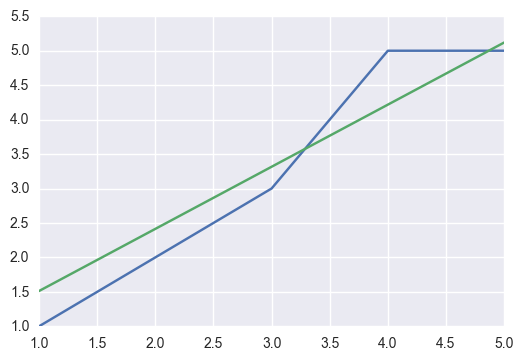

In [3]:
finalmodel = NNRegressor(batch_size=None, random_seed=42, learning_rate=1.0e-3, verbose=1, max_iter=1000, L2=0.1)
Xt = np.array([[1],[2],[3],[4],[5]])
yt = np.array([1,2,3,5,5])
finalmodel.fit(Xt, yt)
pyt = finalmodel.predict(Xt)

plt.plot(Xt[:,0],yt,Xt[:,0],pyt)